In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import math
import pyodbc
import pickle
from sklearn.feature_extraction import text as txt
import nltk
from nltk.corpus import wordnet as wn

In [2]:
#---------Get data from database
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=125.99.16.182;DATABASE=SocialListening;UID=sa;PWD=vikas')
cursor = cnxn.cursor()
sqlCommand = "SELECT * FROM tmpLEads"
cursor.execute(sqlCommand)
results = cursor.fetchone()
text = []
while results:
    text.append(results[0])
    results = cursor.fetchone()
cnxn.close()

In [2]:
#---------FileName where contents are stored
fileName = "F:\Sid\Learnings\Data Scientist\Text Analysis\Leads.txt"
text = []

In [11]:
#-------Save data to disk
with open(fileName, 'wb') as fp:
    pickle.dump(text, fp)

In [3]:
#------REad data from disk
with open (fileName, 'rb') as fp:
    text = pickle.load(fp)

In [5]:
wordsSim = {}

def calcualteStatisticSimilarity(tdm):
    similarity = []
    for item in tdm:
        tmpSim = cosine_similarity(item,tdm)
        #print(tmpSim.shape)
        #val = []
        #--------Iterate over similarities and get top 5 similar values
        #for z_index in np.argsort(tmpSim)[0,0:5]:
        #    val.append(z_index)
        similarity.append(tmpSim)
    return similarity

def allStopWords(feeds):
    dict = {}
    extraWords = set(["?",".","#","he","-"])
    for stmt in feeds:
        for word in stmt.split():
            lowerWord = word.lower()
            if lowerWord in dict:
                dict[lowerWord]+=1
            else:
                dict[lowerWord] = 1     
    for key, value in dict.items():
        if(value < 10):
            extraWords.add(key)
    myStopWords = txt.ENGLISH_STOP_WORDS.union(extraWords)
    return myStopWords

def getMaxSemanticSimilarityBetweenWords(word1,word2):
    if word1 == word2:
        return 1
    
    #---------Check whether the similarity exists or not in dictionary
    dictKey = '_'.join(np.sort([word1,word2]))
    if dictKey in wordsSim:
        return wordsSim[dictKey]
        
    #----------Calculate path similarity    
    word1_syns = wn.synsets(word1)
    word2_syns = wn.synsets(word2)
    itemList = []
    for item_x in word1_syns:
        for item_y in word2_syns:
            itemList.append((item_x,item_y,item_x.path_similarity(item_y)))
            
    max_tuple = ()
    max_sim = 0.0
    for item in itemList:
        if (item[2] != None) and max_sim < item[2]:
            max_sim = item[2]
            
    wordsSim[dictKey] = max_sim
    return max_sim

def removeStopWordsFromString(statement,myStopWords):
    sentence = []
    for word in statement.split():
        if word.lower() not in myStopWords:
            sentence.append(word.lower())
    return ' '.join(sentence)

def cleanFeeds(allFeeds):
    tmpfeeds = []
    myStopWords = allStopWords(allFeeds)
    for val in allFeeds:
        tmpVal = removeStopWordsFromString(val,myStopWords)
        totalWords = len(tmpVal.split())
        if totalWords > 1 and totalWords <= 20:
            tmpfeeds.append(tmpVal)
    return tmpfeeds

def calculateSimilarityBetweenStatements(statement1,statement2):
    if len(statement1) == 0 or len(statement2) == 0:
        return 0,0
    else:
        stmt1_words = statement1.split()
        stmt2_words = statement2.split()
        maxSim = 0
        totalSim = 0
        for word1 in stmt1_words:
            for word2 in stmt2_words:
                #-----------Send words in lowercase
                tmpSim = getMaxSemanticSimilarityBetweenWords(word1.lower(),word2.lower())
                if maxSim < tmpSim:
                    maxSim = tmpSim
            totalSim+= maxSim      
            maxSim = 0
        return totalSim,len(stmt1_words)

def calcualteSemanticSimilarity(feeds):
    SemanticSim = np.ones((len(feeds),len(feeds)))
    for indexOuter in range(len(feeds)):
        if indexOuter %100 == 0:
            print("Outer Index {0} in Progress".format(indexOuter))
        for indexInner in range(indexOuter + 1,len(feeds)):
            if indexInner %1000 == 0:
                print("Inner Index {0} in Progress".format(indexInner))
            sim1,totalWords1 = calculateSimilarityBetweenStatements(feeds[indexOuter],feeds[indexInner])
            sim2,totalWords2 = calculateSimilarityBetweenStatements(feeds[indexInner],feeds[indexOuter])
            calc = 0
            if totalWords1 != 0 and totalWords2 != 0:
                calc = ((sim1/totalWords1) + (sim2/totalWords2))/2
            SemanticSim[indexOuter,indexInner] =calc
    
    #---------Fill the remaining indexes with correct values
    
    for indexOuter in range(len(feeds)-1,0,-1):
        print("outer:", index);
        for indexInner in range(indexOuter-1,-1,-1):
            SemanticSim[indexOuter,indexInner] = SemanticSim[indexInner,indexOuter] 
        
    return SemanticSim

def calculateSimilarity(tdm,feeds):
    SemSim = calcualteSemanticSimilarity(feeds)
    statSim = calcualteStatisticSimilarity(tdm)
    return statSim,SemSim

In [6]:
#create Vectorizer
feeds = cleanFeeds(text)
vectorizer = TfidfVectorizer()
tdm = vectorizer.fit_transform(feeds)

In [ ]:
statSim,SemSim = calculateSimilarity(tdm,feeds)

Outer Index 0 in Progress


In [75]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
x,dict = allStopWords(te)
value_freq = []
for key, value in dict.items():
    if(value<100):
        value_freq.append(value)




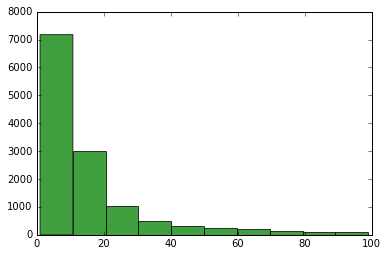

In [83]:
fig = plt.figure()
ax = fig.add_subplot(111)
n,bins,patches = ax.hist(value_freq, normed=0, facecolor='green', alpha=0.75)
plt.show()


In [7]:
len(feeds)

27699